In [1]:
%config Completer.use_jedi = False
import sys, os
sys.path.append('../pyecog2')
sys.path.append('../')
from ProjectClass import Project,FileBuffer
from pyecog2.main import MainModel
import json
import feature_extractor 
import importlib
importlib.reload(feature_extractor)
FeatureExtractor = feature_extractor.FeatureExtractor

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import spectrotools as spec
importlib.reload(spec)
from numba import jit, njit
import timeit

from scipy import stats
import json


Building File Tree...


In [3]:
import colorsys

In [4]:
import pyqtgraph as pg

In [2]:
from scipy.signal import get_window
import classifier
from scipy import linalg

In [7]:
main_model = MainModel()
project=Project(main_model=main_model)
project.load_from_json('/media/mfpleite/LaCie_1/ML_pyecog_2/AwesomeProject_test.pyecog')
fe = FeatureExtractor()

[]
copy from - history reset
[]
copy from - history reset
[]
copy from - history reset
[]
copy from - history reset
looking for h5_119
[]
copy from - history reset
['seizure', 'repeated IIEDs', '(auto)seizure']
copy from - history reset
current animal: h5_119


In [9]:
annotation0 = project.current_animal.annotations.annotations_list[1]
it = project.current_animal.eeg_init_time
index = [i  for i in range(len(it)) if (0<(annotation0.getStart()-it[i])<3600) ][0]
# index=0
fname = '.'.join(project.current_animal.eeg_files[index].split('.')[:-1]+['features'])
# fname ='/media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_119/M1566408624_2019-08-21-18-30-24_tids_[119].features'

f_vec = np.fromfile(fname,dtype='float64')

fmeta_file = '.'.join(project.current_animal.eeg_files[index].split('.')[:-1] + ['fmeta'])
fmeta_dict = json.load(open(fmeta_file))


In [10]:
f_vec = f_vec.reshape((-1,fe.number_of_features))
f_vec[np.where(np.isnan(f_vec))] = 0

In [11]:
starts = [(annotation0.getStart()-it[index])/2.5 for annotation0 in project.current_animal.annotations.annotations_list]
ends = [(annotation0.getEnd()-it[index])/2.5 for annotation0 in project.current_animal.annotations.annotations_list]

f_labels = np.zeros(len(f_vec),dtype='bool')
for i in range(len(starts)-1) :
    s = int(np.floor(starts[i+1]))
    e = int(np.ceil(ends[i+1]))
    f_labels[s:e] = 1
    
f_vec_d  = np.hstack([f_vec,np.vstack([np.zeros(f_vec.shape[1]),np.diff(f_vec,axis=0)])])
f_vec_d  = f_vec
f_vec_d = f_vec_d-np.mean(f_vec_d,axis=0)
f_vec_d = f_vec_d/np.std(f_vec_d,axis = 0)

blanks = f_vec_d#[(1-f_labels).nonzero()[0],:]
seizures = f_vec_d[(f_labels).nonzero()[0],:]

blanks_mu  = blanks.mean(axis=0)
blanks_cov = (blanks-blanks_mu).T.dot((blanks-blanks_mu))/blanks.shape[0]
seizures_mu  = seizures.mean(axis=0)
seizures_cov = (seizures-seizures_mu).T.dot((seizures-seizures_mu))/seizures.shape[0]

[Text(0, 0, 'min'),
 Text(0, -1, 'max'),
 Text(0, -2, 'mean'),
 Text(0, -3, 'log std'),
 Text(0, -4, 'kurtosis'),
 Text(0, -5, 'skewness'),
 Text(0, -6, 'log coastline (log sum of abs diff)'),
 Text(0, -7, 'log power in band (1, 4) Hz'),
 Text(0, -8, 'log power in band (4, 8) Hz'),
 Text(0, -9, 'log power in band (8, 12) Hz'),
 Text(0, -10, 'log power in band (12, 30) Hz'),
 Text(0, -11, 'log power in band (30, 50) Hz'),
 Text(0, -12, 'log power in band (50, 70) Hz'),
 Text(0, -13, 'log power in band (70, 120) Hz'),
 Text(0, -14, 'Spectrum entropy')]

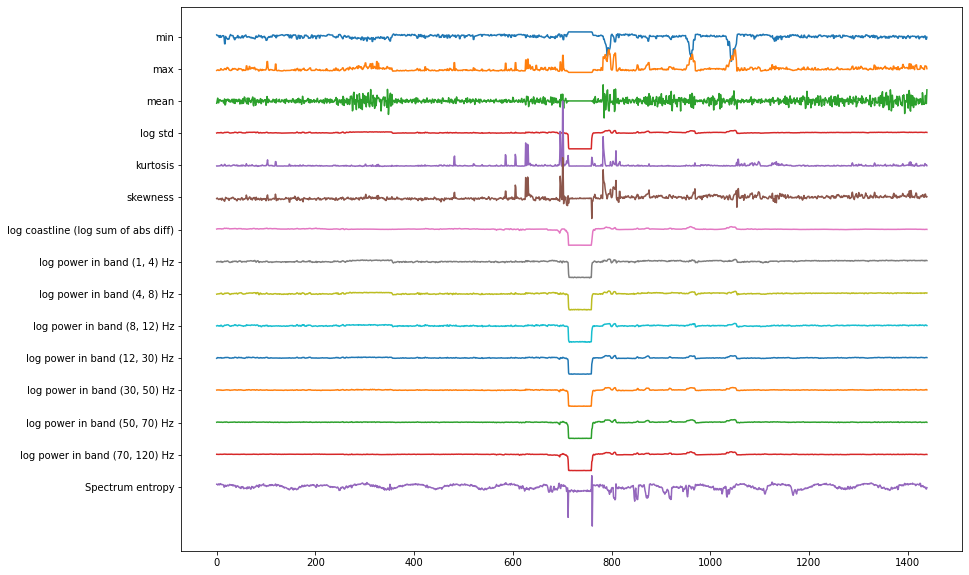

In [12]:

f = plt.figure(figsize=(14,10))
ax = f.gca()
spec.plot_spread(f_vec_d,.5);

# plt.xlim([400,1000])
# plt.vlines(starts[1:],-15,0)
# plt.vlines(ends[1:],-15,0)
ax.set_yticks(range(0,-fe.number_of_features,-1))
ax.set_yticklabels(fe.settings['feature_labels'])

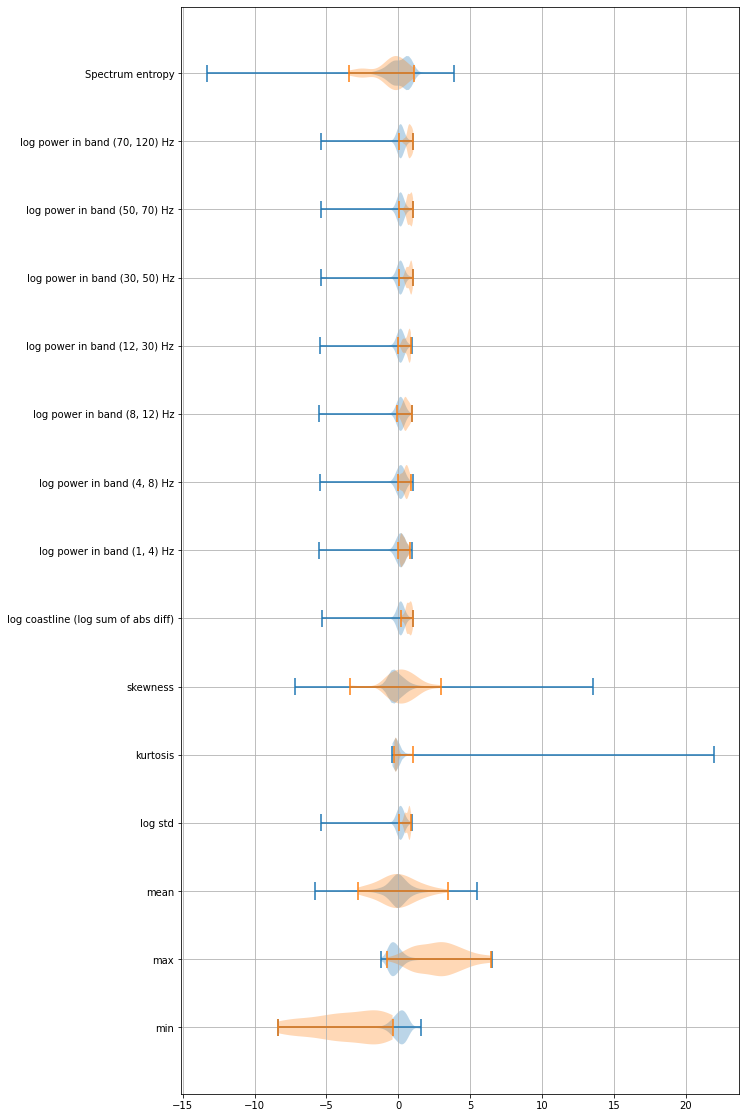

In [13]:
plt.figure(figsize=(10,20))
plt.violinplot(blanks,vert=False);
plt.violinplot(seizures,vert=False);
ax=plt.gca()
# ax.set_yticks(list(range(1,fe.number_of_features+1,1)) + 
#               list(range(fe.number_of_features+1,2*fe.number_of_features+1,1)))
# ax.set_yticklabels(fe.settings['feature_labels'] + ['d'+s+'/dt' for s in fe.settings['feature_labels']])
ax.set_yticks(list(range(1,fe.number_of_features+1,1)))
ax.set_yticklabels(fe.settings['feature_labels'])
plt.grid()

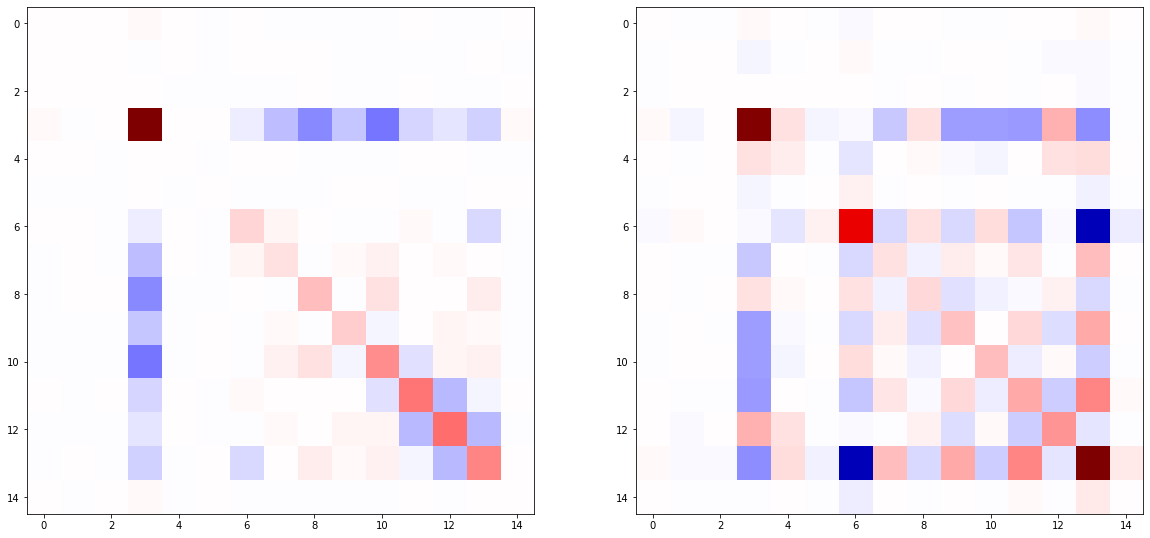

In [14]:
blanks_cov_i = np.linalg.inv(blanks_cov)
seizures_cov_i = np.linalg.inv(seizures_cov)
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(blanks_cov_i,cmap='seismic',vmin=-np.max(np.abs(blanks_cov_i)),vmax=np.max(np.abs(blanks_cov_i)))
plt.subplot(1,2,2)
plt.imshow(seizures_cov_i,cmap='seismic',vmin=-np.max(np.abs(seizures_cov_i)),vmax=np.max(np.abs(seizures_cov_i)))

In [15]:
fe.settings['feature_labels']

['min',
 'max',
 'mean',
 'log std',
 'kurtosis',
 'skewness',
 'log coastline (log sum of abs diff)',
 'log power in band (1, 4) Hz',
 'log power in band (4, 8) Hz',
 'log power in band (8, 12) Hz',
 'log power in band (12, 30) Hz',
 'log power in band (30, 50) Hz',
 'log power in band (50, 70) Hz',
 'log power in band (70, 120) Hz',
 'Spectrum entropy']

In [16]:
@jit(nopython=True)
def MVGD_LL_jit(fdata,mu,inv_cov,LL,no_scale):
    k = fdata.shape[1]
    N = fdata.shape[0]
    scale = (1-no_scale)*((-k/2)*np.log(2*np.pi)+1/2*np.log(np.linalg.det(inv_cov[:,:])))
    for i in range(N):
        LL[i] = scale - 0.5*(fdata[i,:]-mu)@(inv_cov[:,:] @(fdata[i,:]-mu).T)

def MVGD_LL(fdata,mu,inv_cov,no_scale = False):
    LL = np.zeros(fdata.shape[0])
    MVGD_LL_jit(fdata,mu,inv_cov,LL, no_scale)
    return LL

@jit(nopython=True)
def LL2prob_jit(LL,prob):
    for i in range(LL.shape[0]):
        v = np.exp(LL[i,:])
        prob[i,:] = v / np.sum(v)
        
def LL2prob(LL):
    prob = np.zeros(LL.shape)
    LL2prob_jit(LL,prob)
    return prob

<ipython-input-16-da9e4bc747e3>:7: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 1d, C))
  LL[i] = scale - 0.5*(fdata[i,:]-mu)@(inv_cov[:,:] @(fdata[i,:]-mu).T)
/home/mfpleite/anaconda3/envs/pyecog2/lib/python3.8/site-packages/numba-0.52.0-py3.8-linux-x86_64.egg/numba/core/typing/npydecl.py:933: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 1d, C))
  warnings.warn(NumbaPerformanceWarning(msg))


(-500.0, 400.0)

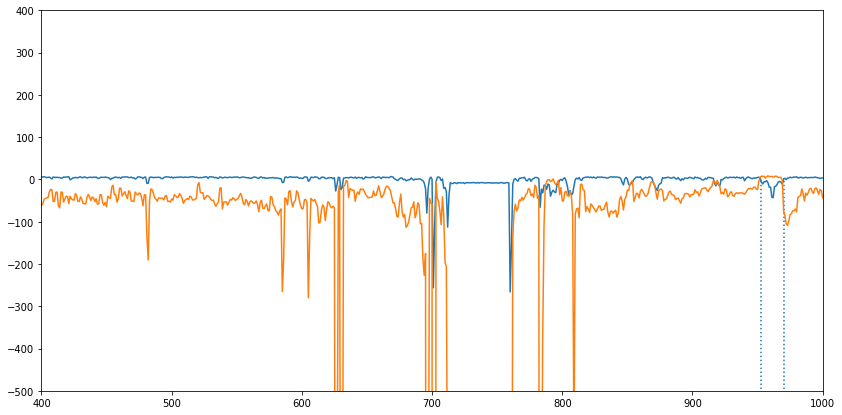

In [17]:
blanks_cov_i = np.linalg.inv(blanks_cov)
blanks_cov_ir = np.linalg.inv(blanks_cov+np.eye(len(blanks_cov))*blanks_cov.diagonal()/len(blanks))

seizures_cov_i = np.linalg.inv(seizures_cov)
seizures_cov_ir = np.linalg.inv(seizures_cov+np.eye(len(seizures_cov))*seizures_cov.diagonal()/len(seizures))

b_LL = MVGD_LL(f_vec_d,blanks_mu,blanks_cov_i)
s_LL = MVGD_LL(f_vec_d,seizures_mu,seizures_cov_i)
b_LLr = MVGD_LL(f_vec_d,blanks_mu,blanks_cov_ir)
s_LLr = MVGD_LL(f_vec_d,seizures_mu,seizures_cov_ir)

plt.figure(figsize=(14,7))
# plt.plot(b_LL)
plt.plot(b_LLr)
# plt.plot(s_LL)
plt.plot(s_LLr)
plt.vlines(starts[1:],-2000,0,linestyles=':')
plt.vlines(ends[1:],-2000,0,linestyles=':')

plt.xlim(400,1000)
plt.ylim(-500,400)

(400.0, 1000.0)

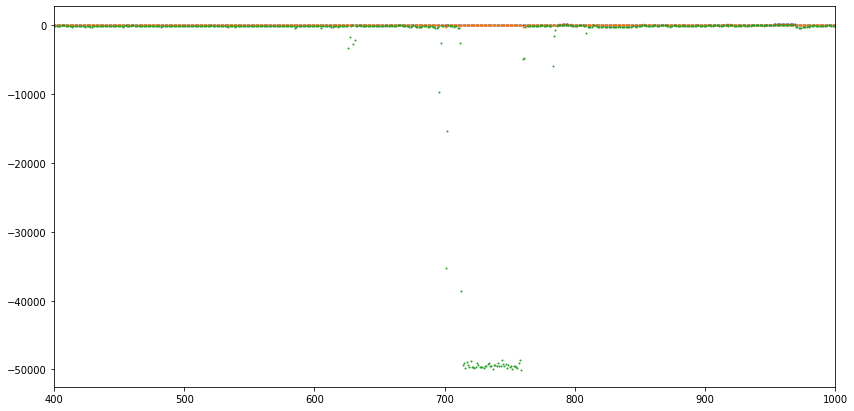

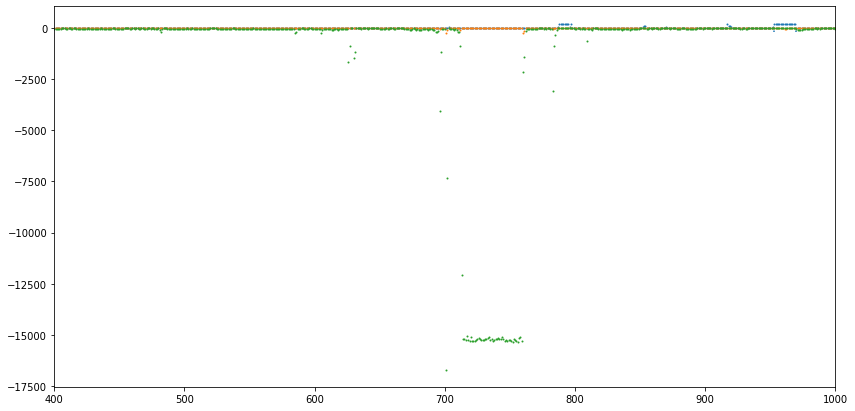

In [18]:
blanks_LL = MVGD_LL(blanks,blanks_mu,blanks_cov_i,no_scale=True)
seizures_LL = MVGD_LL(seizures,seizures_mu,seizures_cov_i,no_scale=True)

blank_bias = np.log(len(blanks)/(len(blanks)+len(seizures)))
seizure_bias = np.log(len(seizures)/(len(blanks)+len(seizures)))


b_LL = MVGD_LL(f_vec_d,blanks_mu,blanks_cov_i)+ blank_bias
s_LL = MVGD_LL(f_vec_d,seizures_mu,seizures_cov_i)+ seizure_bias
b_LLr = MVGD_LL(f_vec_d,blanks_mu,blanks_cov_ir) + blank_bias
s_LLr = MVGD_LL(f_vec_d,seizures_mu,seizures_cov_ir) + seizure_bias

LL = np.array([b_LL.T,s_LL.T]).T
p  = LL2prob(LL) 

LLr = np.array([b_LLr.T,s_LLr.T]).T
pr  = LL2prob(LLr) 

plt.figure(figsize=(14,7))
plt.plot(p[:,1]*200,'.',markersize=2)
plt.plot(pr[:,1]*200,'.',markersize=1,color = [1,0,0,1])
plt.plot(b_LL,'.',markersize=2)
plt.plot(s_LL,'.',markersize=2)
plt.vlines(starts[1:],-200,0,linestyles=':')
plt.vlines(ends[1:],-200,0,linestyles=':')
plt.xlim(400,1000)

plt.figure(figsize=(14,7))
plt.plot(pr[:,1]*200,'.',markersize=2)
plt.plot(b_LLr,'.',markersize=2)
plt.plot(s_LLr,'.',markersize=2)
plt.vlines(starts[1:],-200,0,linestyles=':')
plt.vlines(ends[1:],-200,0,linestyles=':')
plt.xlim(400,1000)

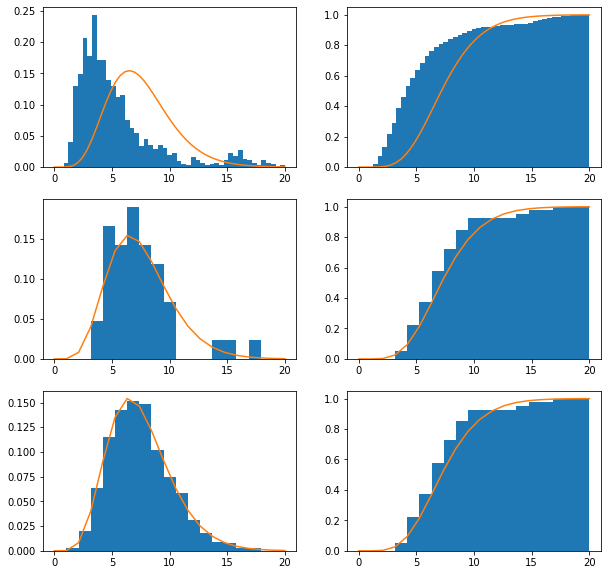

In [19]:
plt.figure(figsize=(10,10))
dof = f_vec.shape[1]
x = np.linspace(0,20,50)
chi2 = stats.chi2.pdf(x,dof,scale=0.5)
plt.subplot(321)
plt.hist(-blanks_LL,bins = x,density = True);
plt.plot(x,chi2)

cum_chi2 = stats.chi2.cdf(x,dof,scale=0.5)
plt.subplot(322)
plt.hist(-blanks_LL,bins = x,density = True,cumulative=True);
plt.plot(x,cum_chi2)

x = np.linspace(0,20,20)
chi2 = stats.chi2.pdf(x,dof,scale=0.5)
# plt.figure()
plt.subplot(323)
plt.hist(-seizures_LL,bins=x,density=True);
plt.plot(x,chi2)

cum_chi2 = stats.chi2.cdf(x,dof,scale=0.5)
plt.subplot(324)
plt.hist(-seizures_LL,bins = x,density=True,cumulative=True);
plt.plot(x,cum_chi2)


f_rand = np.random.randn(*f_vec.shape)
LL_rand = 0.5*np.sum(f_rand**2,axis = 1)
x = np.linspace(0,20,20)
chi2 = stats.chi2.pdf(x,dof,scale=0.5)
# plt.figure()
plt.subplot(325)
plt.hist(LL_rand,bins=x,density=True);
plt.plot(x,chi2)

cum_chi2 = stats.chi2.cdf(x,dof,scale=0.5)
plt.subplot(326)
plt.hist(-seizures_LL,bins = x,density = True,cumulative=True);
plt.plot(x,cum_chi2)





In [20]:
main_model = MainModel()
project=Project(main_model=main_model)
project.load_from_json('/media/mfpleite/LaCie_1/ML_pyecog_2/AwesomeProject_IIEDs.pyecog')

[]
copy from - history reset
[]
copy from - history reset
[]
copy from - history reset
[]
copy from - history reset
looking for h5_119
[]
copy from - history reset
['seizure', 'repeated IIEDs', '(auto)seizure']
copy from - history reset
current animal: h5_119


In [130]:
import classifier
from scipy import linalg

importlib.reload(classifier)

<module 'classifier' from '../pyecog2/classifier.py'>

In [131]:
a = {'b':1,'c':2}

In [132]:
for key,i in a.items():
    print(key,i)

b 1
c 2


In [133]:
GC = classifier.GaussianClassifier(project,fe,['seizure','repeated IIEDs'])
GC2 = classifier.GaussianClassifier(project,fe,['seizure','repeated IIEDs'])
GC3 = classifier.GaussianClassifier(project,fe,['seizure','repeated IIEDs'])

In [134]:
GC.whitening_mu_W_iW()

(array([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]]),
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0

In [135]:
project.current_animal.annotations.labels

['seizure', 'repeated IIEDs', '(auto)seizure', '(auto)repeated IIEDs']

In [136]:
GC.train(project.animal_list[:1])

Training with animal: h5_119
Training with classes: ['seizure' 'repeated IIEDs']


Animal: h5_119

Transitions:19 file: 1709 of 1710 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_119/M1572561642_2019-10-31-22-40-42_tids_[119].features
 [[ 0. 11. 39.]
 [11.  0.  0.]
 [39.  0.  1.]]


In [137]:
GC2.train(project.animal_list[1:2])

Training with animal: h5_120
Training with classes: ['seizure' 'repeated IIEDs']


Animal: h5_120

Animal: h5_120 

Transitions:
 [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


In [138]:
GC3.train(project.animal_list[1:2])

Training with animal: h5_120
Training with classes: ['seizure' 'repeated IIEDs']
Transitions:20 file: 1691 of 1692 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_120/M1572561642_2019-10-31-22-40-42_tids_[120].featuresle: 79 of 1692 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_120/M1566757824_2019-08-25-19-30-24_tids_[120].features file: 374 of 1692 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_120/M1567817359_2019-09-07-01-49-19_tids_[120].features /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_120/M1568335759_2019-09-13-01-49-19_tids_[120].features file: 1633 of 1692 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_120/M1572352842_2019-10-29-12-40-42_tids_[120].features
 [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


In [139]:
GC2.copy_re_normalized_classifier(GC)

In [140]:
mu3,W3,iW3 = GC3.whitening_mu_W_iW()
mu2,W2,iW2 = GC2.whitening_mu_W_iW()
mu,W,iW = GC.whitening_mu_W_iW()

<IPython.core.display.Javascript object>


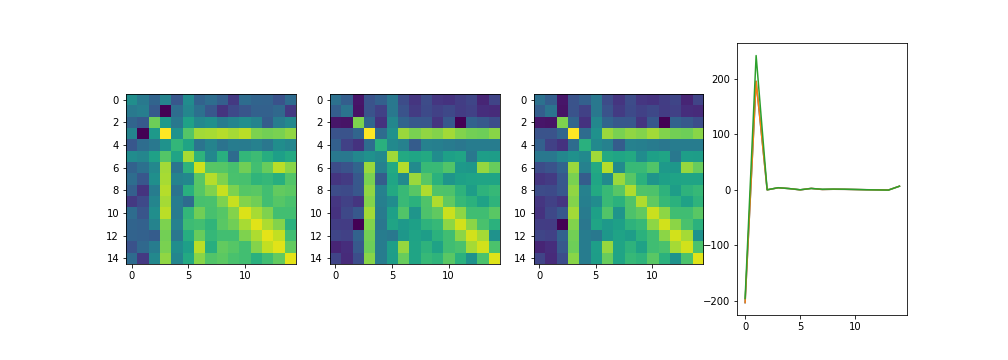

In [141]:
plt.figure(figsize=(14,5))
plt.subplot(1,4,1)
plt.imshow(np.log(np.abs(W)))
plt.subplot(1,4,2)
plt.imshow(np.log(np.abs(W2)))
plt.subplot(1,4,3)
plt.imshow(np.log(np.abs(W3)))
plt.subplot(1,4,4)
plt.plot(mu3)
plt.plot(mu2)
plt.plot(mu)

<IPython.core.display.Javascript object>


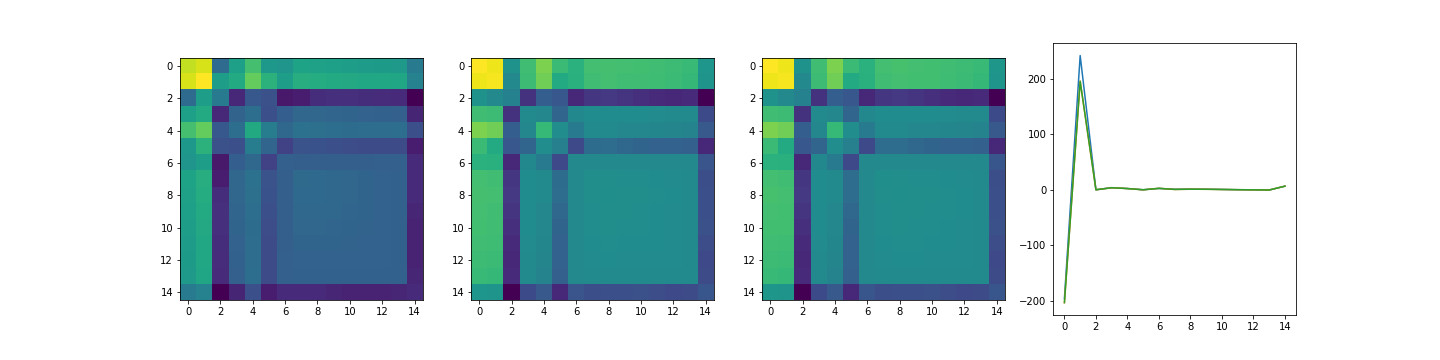

In [144]:
plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plt.imshow(np.log(np.abs(GC.blank_cov)))
plt.subplot(1,4,2)
plt.imshow(np.log(np.abs(GC2.blank_cov)))
plt.subplot(1,4,3)
plt.imshow(np.log(np.abs(GC3.blank_cov)))
plt.subplot(1,4,4)
plt.plot(GC.blank_means)
plt.plot(GC2.blank_means)
plt.plot(GC3.blank_means)

<IPython.core.display.Javascript object>


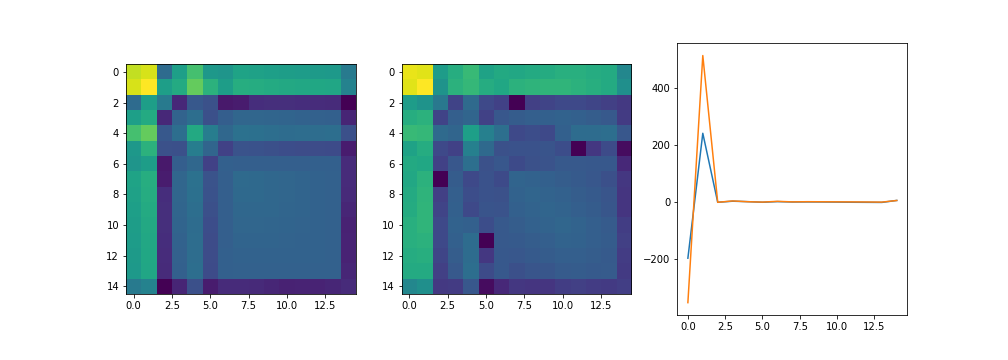

<IPython.core.display.Javascript object>


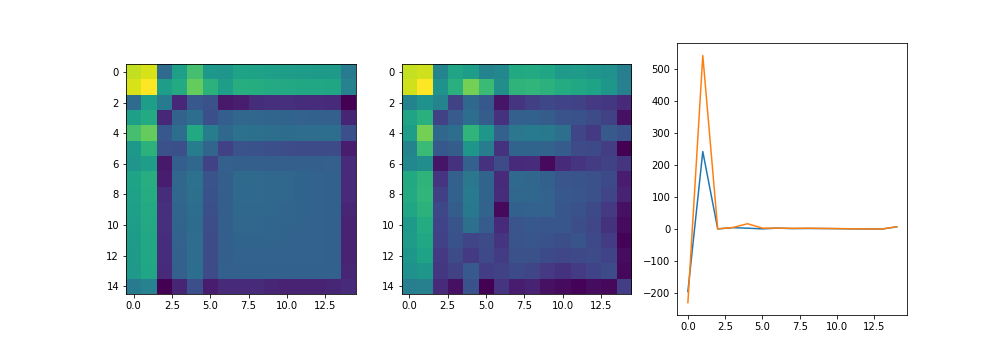

In [145]:
mu = GC.blank_means[:,np.newaxis]
cov = GC.blank_cov
npoints = GC.blank_npoints
for i in range(len(GC.labels2classify)):
    muc = GC.class_means[i][:,np.newaxis]
    covc = GC.class_cov[i]
    npointsc = GC.class_npoints[i]
    plt.figure(figsize=(14,5))
    plt.subplot(1,3,1)
    plt.imshow(np.log(np.abs(cov)))
    plt.subplot(1,3,2)
    plt.imshow(np.log(np.abs(covc)))
    plt.subplot(1,3,3)
    plt.plot(mu)
    plt.plot(muc)
    mu,cov = classifier.average_mu_and_cov(mu,cov,npoints,muc,covc,npointsc)
    npoints += npointsc

In [146]:
npoints

4922138

In [147]:
GC.blank_npoints

4919576

In [148]:
GC.class_means

array([[-3.51423919e+02,  5.13779225e+02,  1.80570806e-03,
         4.69156231e+00,  2.00169265e+00,  6.85473763e-01,
         3.24363660e+00,  1.42822727e+00,  2.00751396e+00,
         1.79039369e+00,  1.51050439e+00,  1.32233453e+00,
         1.04094879e+00,  5.89191443e-01,  6.26568352e+00],
       [-2.30474727e+02,  5.41701138e+02,  7.51830549e-03,
         4.24010831e+00,  1.61132161e+01,  2.37871420e+00,
         2.43018066e+00,  1.71032252e+00,  2.12867280e+00,
         1.64366436e+00,  9.81190247e-01,  3.10202299e-01,
        -3.23120963e-02, -3.94742712e-01,  6.51770913e+00]])

<IPython.core.display.Javascript object>


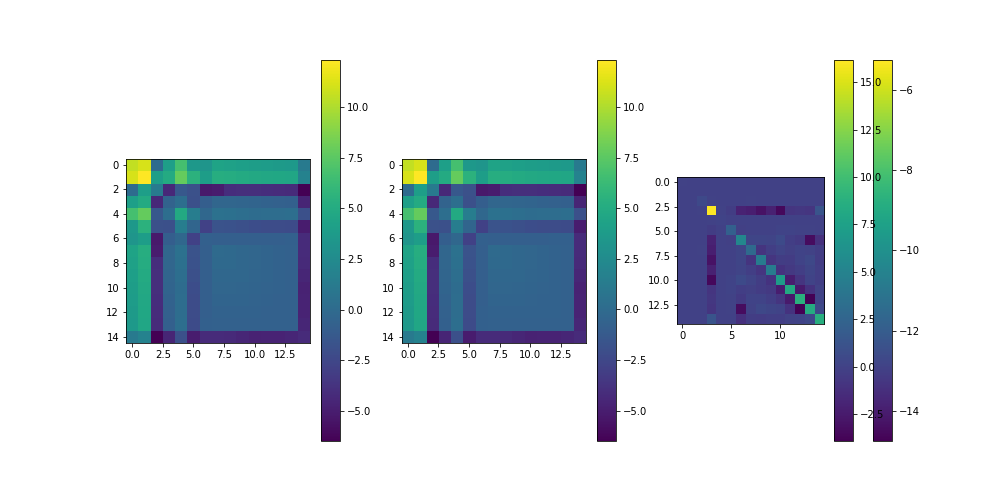

In [149]:
plt.figure(figsize=(14,7))
plt.subplot(1,3,1)
plt.imshow(np.log(np.abs(cov)))
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(np.log(np.abs(GC.blank_cov)))
plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(np.log(np.abs(GC.blank_cov-cov))-np.log(np.abs(GC.blank_cov)))
# plt.imshow(np.log(np.abs(A)))
plt.colorbar()

In [150]:
A = linalg.sqrtm(classifier.reg_invcov(GC.blank_cov,GC.blank_npoints))

In [151]:
plt.imshow(A)
plt.colorbar()

In [152]:
error = A@GC.blank_cov@A.T - np.eye(GC.Ndim)

<IPython.core.display.Javascript object>


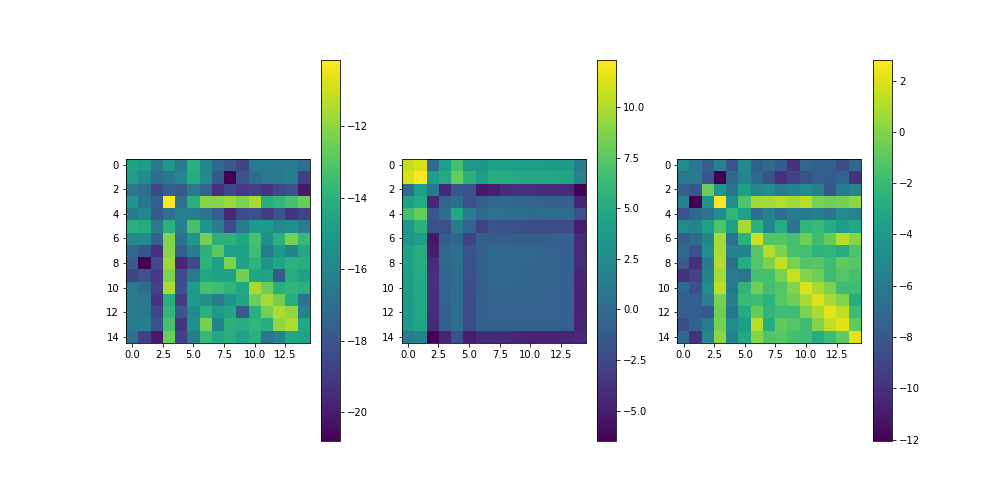

In [153]:
plt.figure(figsize=(14,7))
plt.subplot(1,3,1)
plt.imshow(np.log(np.abs(error)))
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(np.log(np.abs(GC.blank_cov)))
plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(np.log(np.abs(A)))
plt.colorbar()


In [154]:
# GC2._debug_f_vec_d.shape

In [155]:
# f = plt.figure(figsize=(14,10))
# ax = f.gca()
# spec.plot_spread(GC2._debug_f_vec_d[:,-4:],.5);

In [156]:
import spectrotools as spec

<IPython.core.display.Javascript object>


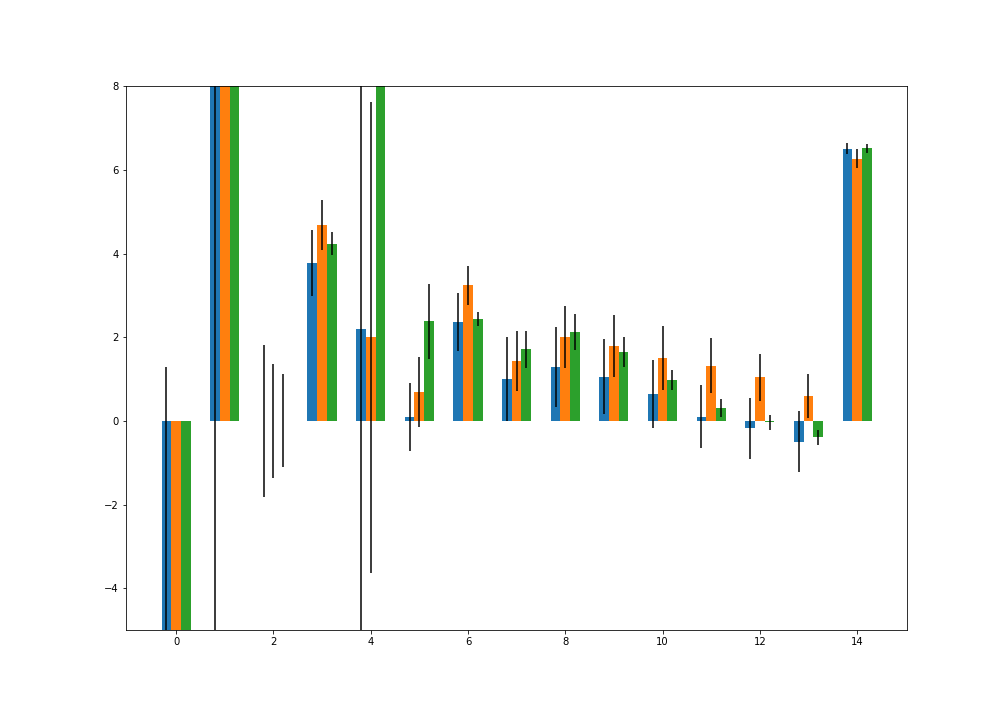

(-5.0, 8.0)

In [157]:
plt.figure(figsize=(14,10))
blank_std = np.sqrt(np.diag(GC.blank_cov))
class_std0 = np.sqrt(np.diag(GC.class_cov[0]))
class_std1 = np.sqrt(np.diag(GC.class_cov[1]))
# plt.plot(GC.blank_means[:],'k')
# plt.plot(GC.blank_means[:]+blank_std,'k:')
# plt.plot(GC.blank_means[:]-blank_std,'k:')
# plt.ylim([-10,10])
# plt.plot(GC.class_means[0,:],'b')
# plt.plot(GC2.class_means[0,:],'b:')
plt.bar(np.arange(GC.Ndim)-.2,GC.blank_means[:],yerr=blank_std,width=.2)
plt.bar(np.arange(GC.Ndim),GC.class_means[0,:],yerr=class_std0,width=.2)
plt.bar(np.arange(GC.Ndim)+.2,GC.class_means[1,:],yerr=class_std1,width=.2)
plt.ylim([-5,8])

<IPython.core.display.Javascript object>


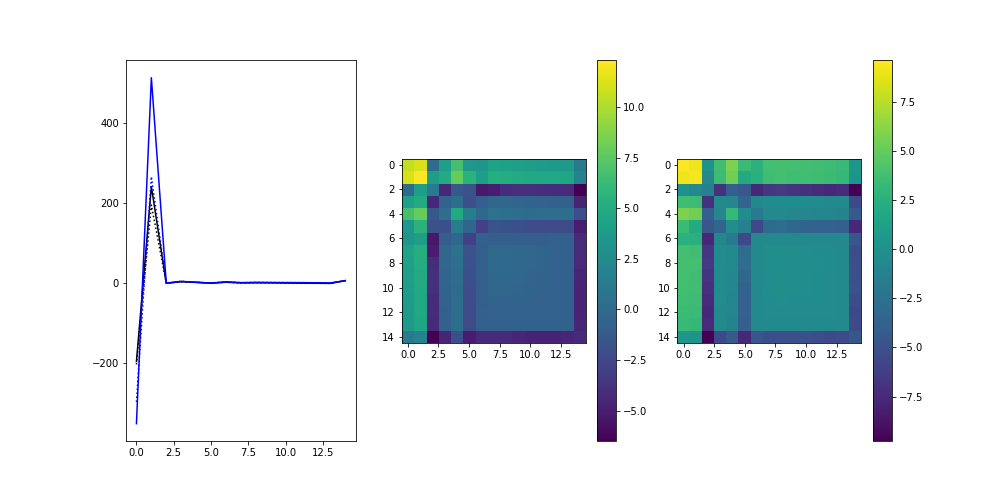

In [158]:
plt.figure(figsize=(14,7))
plt.subplot(1,3,1)
plt.plot(GC.blank_means,'k')
plt.plot(GC2.blank_means,'k:')
plt.plot(GC.class_means[0,:],'b')
plt.plot(GC2.class_means[0,:],'b:')
plt.subplot(1,3,2)
plt.imshow(np.log(np.abs(GC.blank_cov)))
plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(np.log(np.abs(GC2.blank_cov)))
plt.colorbar()


In [159]:
project.animal_list[1].id

'h5_120'

In [160]:
(LLv,R2v,pf,timev) = GC.classify_animal(project.current_animal,max_annotations=100)

../pyecog2/classifier.py:25: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, F))
  LL[i] =( scale - 0.5*(fdata[i,:]-mu)@(inv_cov[:,:] @(fdata[i,:]-mu).T))[0,0]  # the [0,0] is for numba wizzardry to work
/home/mfpleite/anaconda3/envs/pyecog2/lib/python3.8/site-packages/numba-0.52.0-py3.8-linux-x86_64.egg/numba/core/typing/npydecl.py:933: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, F))
  warnings.warn(NumbaPerformanceWarning(msg))


Animal: h5_119 file: 1709 of 1710 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_119/M1572561642_2019-10-31-22-40-42_tids_[119].fmeta5_119 file: 117 of 1710 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_119/M1566829824_2019-08-26-15-30-24_tids_[119].fmeta h5_119 file: 156 of 1710 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_119/M1566970224_2019-08-28-06-30-24_tids_[119].fmeta/media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_119/M1567179024_2019-08-30-16-30-24_tids_[119].fmeta/media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_119/M1567319424_2019-09-01-07-30-24_tids_[119].fmeta h5_119 file: 272 of 1710 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_119/M1567387824_2019-09-02-02-30-24_tids_[119].fmeta h5_119 file: 347 of 1710 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_119/M1567657824_2019-09-05-05-30-24_tids_[119].fmeta h5_119 file: 939 of 1710 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_119/M1569790159_2019-09-29-21-49-19_tids_[119].fme

len starts 12670
manual label positions: [[1567106621.5, 1567106871.5], [1568798289.0, 1568798464.0], [1568118001.5, 1568118156.5], [1566729901.5, 1566730054.0], [1566449896.5, 1566450059.0], [1567295086.5, 1567295229.0], [1566797226.5, 1566797416.5], [1566809499.0, 1566809664.0], [1566891179.0, 1566891414.0], [1566920476.5, 1566920636.5], [1566921004.0, 1566921151.5], [1566425814.0, 1566425939.0], [1570464304.0, 1570464499.0], [1568370724.0, 1568370866.5], [1566448011.5, 1566448121.5], [1568798466.5, 1568798624.0], [1567591111.5, 1567591254.0], [1566452956.5, 1566453109.0], [1566449189.0, 1566449329.0], [1568370954.0, 1568371076.5], [1566451064.0, 1566451176.5], [1568723294.0, 1568723479.0], [1570442044.0, 1570442329.0], [1566708661.5, 1566708779.0], [1566809831.5, 1566809956.5], [1568813729.0, 1568813834.0], [1568364251.5, 1568364369.0], [1567019856.5, 1567019986.5], [1566999521.5, 1566999626.5], [1567536504.0, 1567536604.0], [1567813624.0, 1567813749.0], [1566704026.5, 1566704139.0]

In [40]:
(LLv,R2v,pf,timev) = GC2.classify_animal(project.animal_list[1],max_annotations=100)

Animal: h5_120 file: 1691 of 1692 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_120/M1572561642_2019-10-31-22-40-42_tids_[120].fmetah5_120 file: 215 of 1692 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_120/M1567247424_2019-08-31-11-30-24_tids_[120].fmeta/media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_120/M1567758624_2019-09-06-09-30-24_tids_[120].fmetafile: 445 of 1692 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_120/M1568072959_2019-09-10-00-49-19_tids_[120].fmeta h5_120 file: 624 of 1692 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_120/M1568720959_2019-09-17-12-49-19_tids_[120].fmeta h5_120 file: 766 of 1692 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_120/M1569232159_2019-09-23-10-49-19_tids_[120].fmeta h5_120 file: 820 of 1692 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_120/M1569426559_2019-09-25-16-49-19_tids_[120].fmeta of 1692 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_120/M1569620959_2019-09-27-22-49-19_tids_[120].f

In [ ]:
# project.save_to_json(fname = project.project_file[:-7]+'_test.pyecog')

<ipython-input-43-cb23d19ecc95>:2: RuntimeWarning: divide by zero encountered in log
  plt.plot(-np.log(1-pf.T),'.', markersize=1)


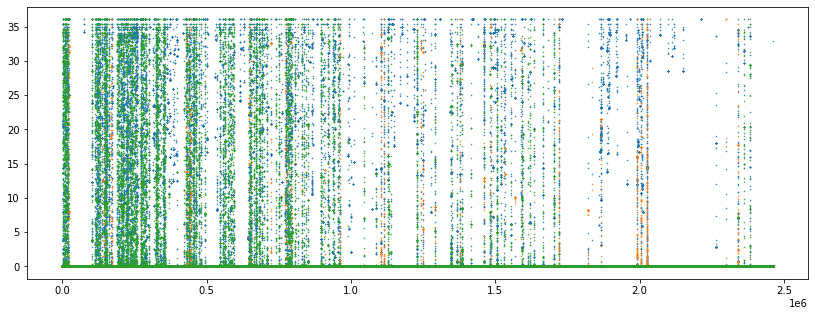

In [43]:
plt.figure(figsize=(14,5))
plt.plot(-np.log(1-pf.T),'.', markersize=1)
# plt.ylim(-100,50)

<IPython.core.display.Javascript object>


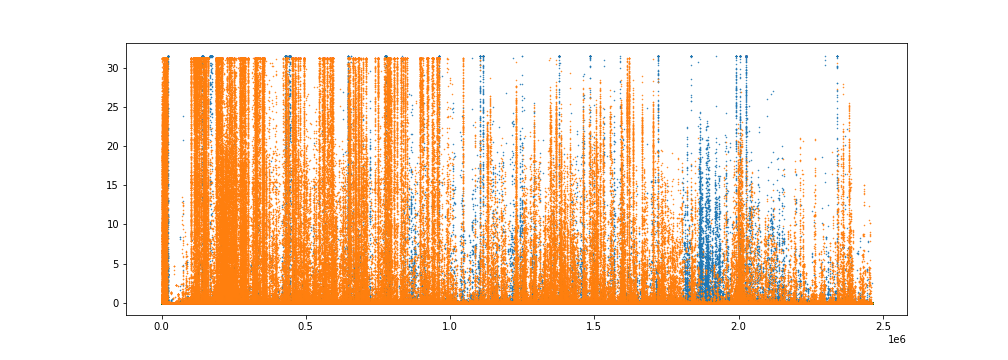

In [163]:
plt.figure(figsize=(14,5))
plt.plot(-np.log(1-pf[1:,:].T),'.', markersize=1)
# plt.ylim(-100,50)

In [44]:
GC.labels2classify

array(['seizure', 'repeated IIEDs'], dtype='<U14')

In [91]:
th = stats.chi2.isf(1e-3,GC.Ndim,scale=0.5)

In [92]:
th

18.848649109176915

In [112]:
len(R2v)

2461208

In [111]:
i=1
np.sum(((pf[i, :].T * (-R2v[:, i] < th)) > .5).astype('int'))/len(R2v)

0.005620817094694963

<IPython.core.display.Javascript object>


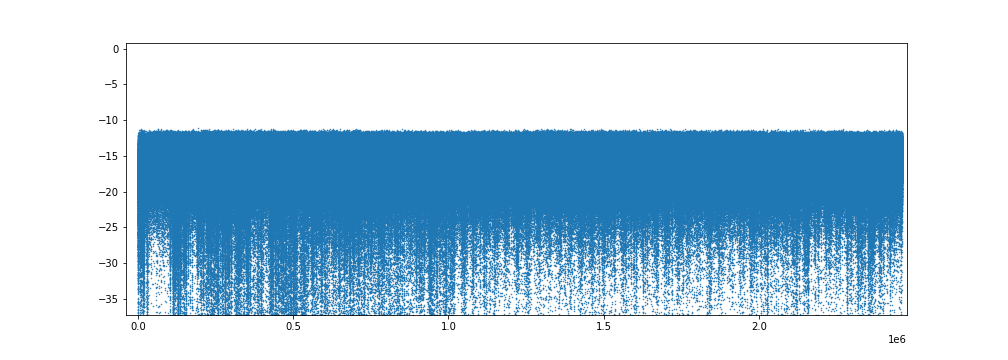

In [57]:
%matplotlib notebook
plt.figure(figsize=(14,5))
plt.plot(R2v[:,0],'.', markersize=1)

<IPython.core.display.Javascript object>


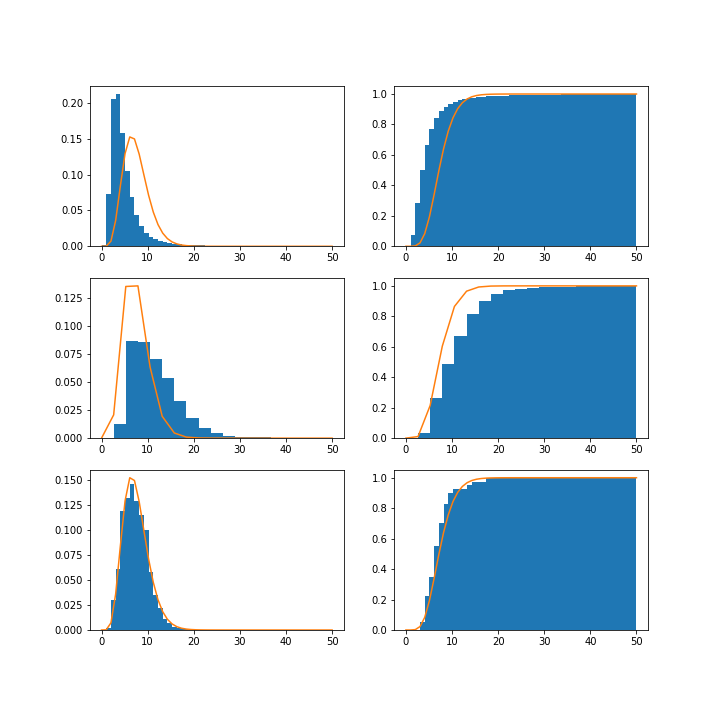

In [104]:
plt.figure(figsize=(10,10))
dof = GC.Ndim
x = np.linspace(0,50,50)
chi2 = stats.chi2.pdf(x,dof,scale=0.5)
plt.subplot(321)
plt.hist(-R2v[:,0],bins = x,density = True);
plt.plot(x,chi2)

cum_chi2 = stats.chi2.cdf(x,dof,scale=0.5)
plt.subplot(322)
plt.hist(-R2v[:,0],bins = x,density = True,cumulative=True);
plt.plot(x,cum_chi2)


x = np.linspace(0,50,20)
chi2 = stats.chi2.pdf(x,dof,scale=0.5)
# plt.figure()
plt.subplot(323)
plt.hist(-R2v[:,1],bins=x,density=True);
plt.plot(x,chi2)

cum_chi2 = stats.chi2.cdf(x,dof,scale=0.5)
plt.subplot(324)
plt.hist(-R2v[:,1],bins = x,density=True,cumulative=True);
plt.plot(x,cum_chi2)


f_rand = np.random.randn(*f_vec.shape)
LL_rand = 0.5*np.sum(f_rand**2,axis = 1)
x = np.linspace(0,50,50)
chi2 = stats.chi2.pdf(x,dof,scale=0.5)
# plt.figure()
plt.subplot(325)
plt.hist(LL_rand,bins=x,density=True);
plt.plot(x,chi2)

cum_chi2 = stats.chi2.cdf(x,dof,scale=0.5)
plt.subplot(326)
plt.hist(-seizures_LL,bins = x,density = True,cumulative=True);
plt.plot(x,cum_chi2)



<IPython.core.display.Javascript object>


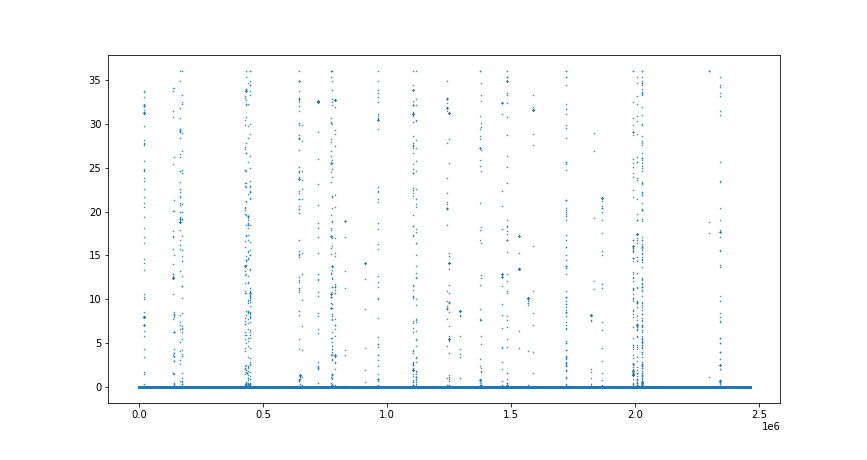

<ipython-input-46-7e7d0c165190>:3: RuntimeWarning: divide by zero encountered in log
  plt.plot(-np.log(1-pf[1,:]),'.', markersize=1)


In [46]:
%matplotlib notebook
plt.figure(figsize=(14,5))
plt.plot(-np.log(1-pf[1,:]),'.', markersize=1)
# plt.ylim(-100,50)

(2461208, 3)

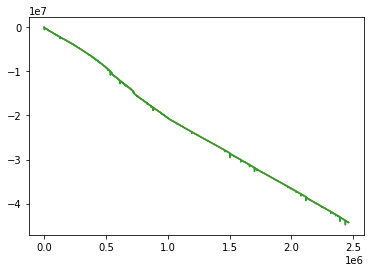

In [71]:
plt.plot(GC.hmm.alpha.T)
# plt.plot(GC.hmm.beta.T)

<IPython.core.display.Javascript object>


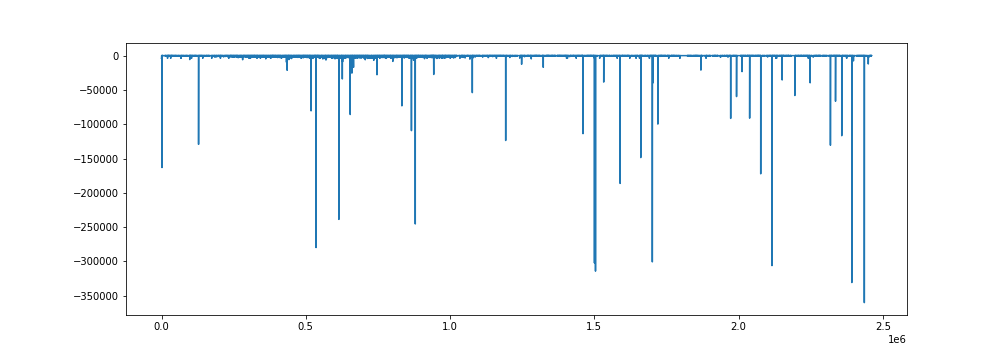

In [115]:
plt.figure(figsize=(14,5))
plt.plot(LLv[:,1]-LLv[:,0], markersize=1)
plt.plot(np.where(np.isfinite(LLv[:,1]-LLv[:,0]),np.nan,1),'*')

plt.plot(np.where(np.isfinite(LLv[:,0]),np.nan,20000),'*')
plt.plot(np.where(np.isfinite(LLv[:,1]),np.nan,10000),'*')

In [119]:
_,_,total_npoints = GC.all_mu_and_cov()

In [125]:
 np.log(total_npoints)

15.409253546923276

In [122]:
_,_,total_npoints = GC.all_mu_and_cov()
LLv_reg = np.maximum((np.max(LLv,axis=1) - np.log(total_npoints))[:,np.newaxis],LLv)

<IPython.core.display.Javascript object>


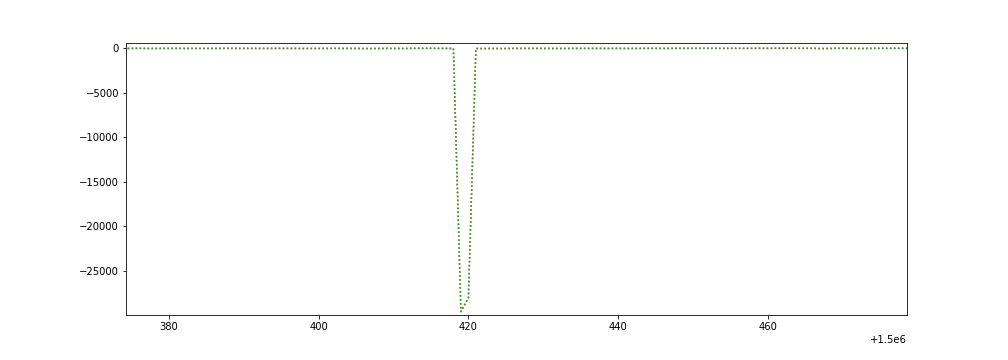

In [129]:
plt.figure(figsize=(14,5))
# plt.plot(LLv, linewidth=.5)
plt.plot(LLv_reg,':')
# plt.ylim(-1000,1000)

In [27]:
print(GC.hmm.A)
print(GC.hmm.phi)

[[9.99997562e-01 2.43796794e-06]
 [4.22535211e-02 9.57746479e-01]]
[[ -247.60718107  -247.51882057  -247.83037244 ...   -12.64143888
    -13.13367215   -60.14581098]
 [-4102.65662991 -4157.71035082 -4092.1385822  ...   -21.2091908
    -20.00942799   -33.10859413]]


In [28]:
GC.hmm.alpha.dtype

dtype('float64')

(-1000.0, 1000.0)

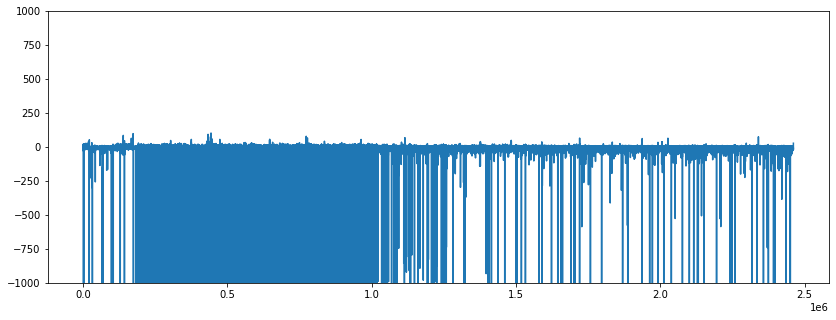

In [29]:
plt.figure(figsize=(14,5))
plt.plot(LLv[:,1]-LLv[:,0], markersize=1)
plt.ylim(-1000,1000)

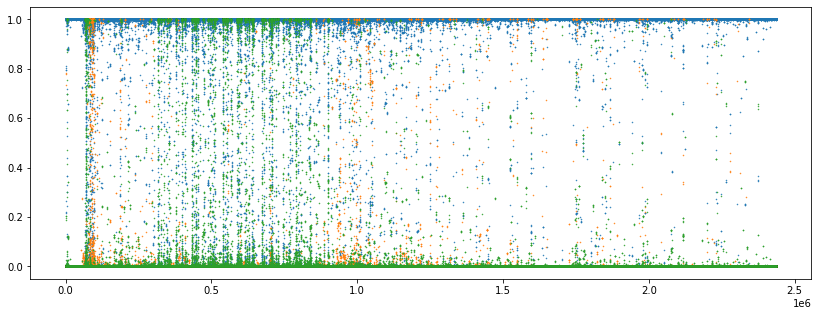

In [21]:
plt.figure(figsize=(14,5))
plt.plot(pf.T,'.', markersize=1)

<ipython-input-20-1aa7656eef08>:2: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(pf.T)-np.log(np.maximum(1-pf.T,1e-12)),'.', markersize=1)


(-100.0, 50.0)

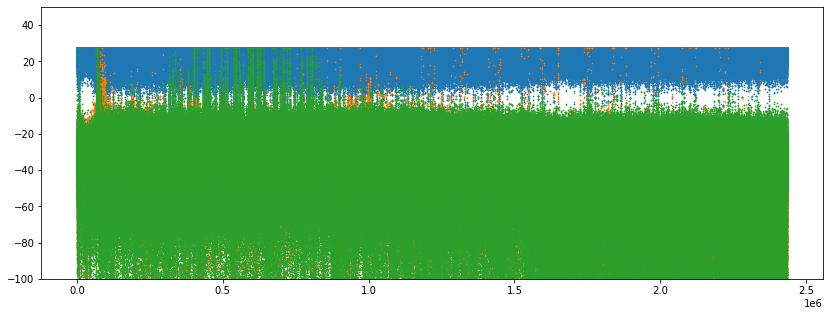

In [20]:
plt.figure(figsize=(14,5))
plt.plot(np.log(pf.T)-np.log(np.maximum(1-pf.T,1e-12)),'.', markersize=1)
plt.ylim(-100,50)

In [32]:
np.log(np.maximum(1-pf.T,1e-12))

array([[-2.76310211e+01,  0.00000000e+00],
       [-2.76310211e+01,  0.00000000e+00],
       [-2.76310211e+01,  0.00000000e+00],
       ...,
       [-1.55306545e+01, -1.79937837e-07],
       [-6.91973280e+00, -9.88582414e-04],
       [-7.42040096e-07, -1.41138629e+01]])

In [152]:
project.current_animal.annotations.labels

['seizure', 'repeated IIEDs', '(auto)seizure']

In [153]:
len(project.current_animal.annotations.annotations_list)

102

In [17]:
project.project_file[:-7]

'/media/mfpleite/LaCie_1/ML_pyecog_2/AwesomeProject_IIEDs'

In [18]:
project.save_to_json(fname = project.project_file[:-7]+'_test.pyecog')

In [149]:
# f_vec_d = np.hstack([f_vec, np.vstack([np.zeros(f_vec.shape[1]), np.diff(f_vec, axis=0)])])
LL = GC.log_likelyhoods(f_vec,bias=True,no_scale=False)

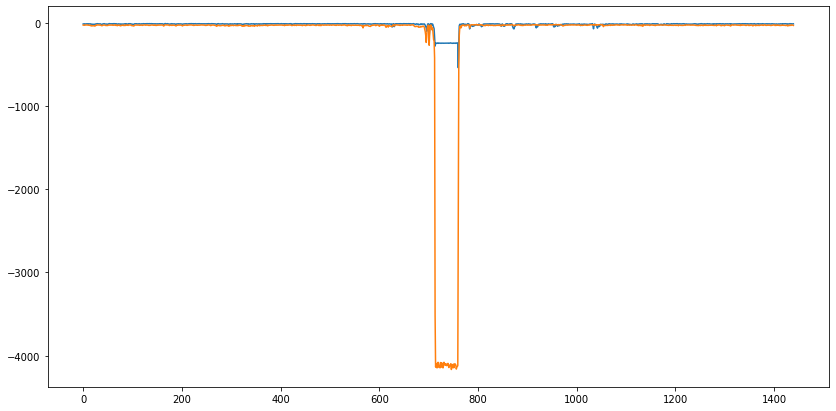

In [150]:
plt.figure(figsize=(14,7))
plt.plot(LL)

In [620]:
print(np.linalg.det(blanks_cov),np.linalg.det(GC.class_cov[0]))

0.000582672948028742 0.28223231073679556


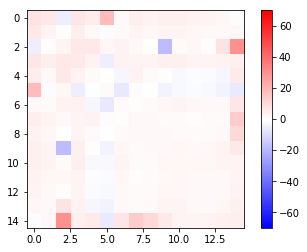

In [621]:
plt.imshow(GC.class_cov[0]/blanks_cov,cmap='bwr',vmin=-70,vmax=70)
plt.colorbar()

In [622]:
@jit(nopython=True)
def LL2prob_jit(LL,prob):
    for i in range(LL.shape[0]):
        v = np.exp(LL[i,:])
        prob[i,:] = v / np.sum(v)
        
def LL2prob(LL):
    prob = np.zeros(LL.shape)
    LL2prob_jit(LL,prob)
    return prob

In [623]:
p = LL2prob(LL)

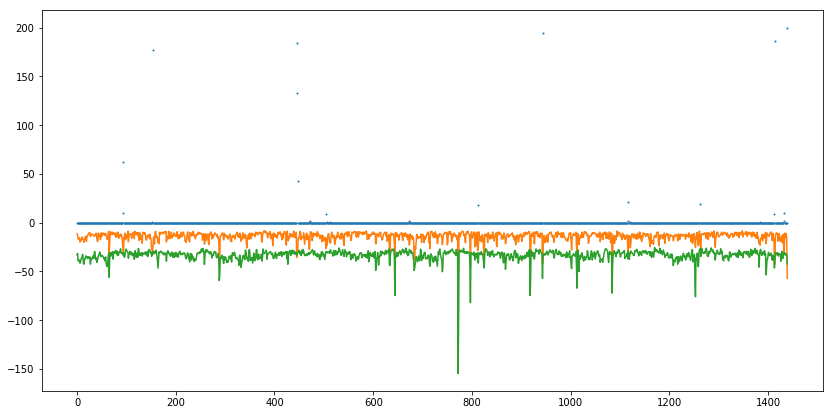

In [624]:
plt.figure(figsize=(14,7))
plt.plot(p[:,1]*200,'.',markersize=2)
plt.plot(LL[:,0])
# plt.plot(b_LLr)
plt.plot(LL[:,1])
# plt.plot(s_LLr)
# plt.vlines(starts[1:],-1000,0,linestyles=':')
# plt.vlines(ends[1:],-1000,0,linestyles=':')
# plt.xlim(400,1000)/

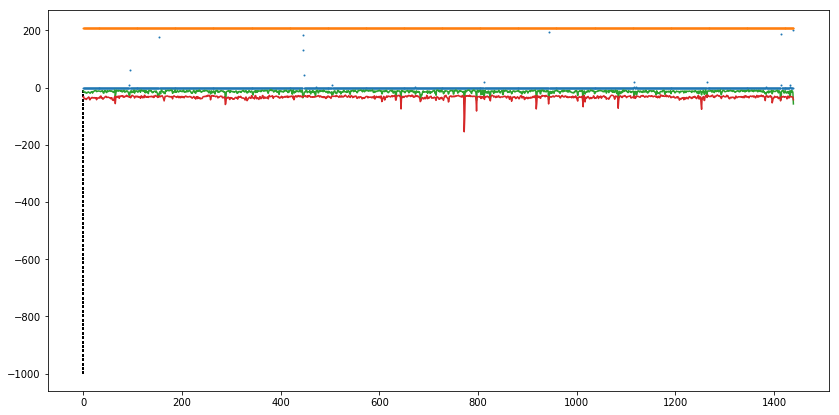

In [625]:
plt.figure(figsize=(14,7))
plt.plot(p[:,1]*200,'.',markersize=2)
plt.plot(p[:,2]*200+210,'.',markersize=2)
plt.plot(LL[:,0])
# plt.plot(b_LLr)
plt.plot(LL[:,1])
# plt.plot(s_LLr)
plt.vlines(starts[1:],-1000,0,linestyles=':')
plt.vlines(ends[1:],-1000,0,linestyles=':')
# plt.xlim(400,1000)/

In [699]:
LLv = []
R2v = []
drawplots = False

project.current_animal.eeg_files.sort()
for eegfname in project.current_animal.eeg_files:
    fname = '.'.join(eegfname.split('.')[:-1]+['features'])
    f_vec = np.fromfile(fname,dtype='float64')
    f_vec = f_vec.reshape((-1,fe.number_of_features))
#     f_vec = np.hstack([f_vec, np.vstack([np.zeros(f_vec.shape[1]), np.diff(f_vec, axis=0)])])
    LL = GC.log_likelyhoods(f_vec,bias=False,no_scale=False)
    R2 = GC.log_likelyhoods(f_vec,bias=False,no_scale=True)
    LLv.append(LL)
    R2v.append(R2)
    p  = LL2prob(LL) 
    if drawplots:
        plt.figure(figsize=(14,7))
        plt.plot(p[:,1]*200,'.',markersize=2)
        plt.plot(LL[:,0],'.',markersize=2)
        plt.plot(LL[:,1],'.',markersize=2)
        plt.vlines(starts[1:],-1000,0,linestyles=':')
        plt.vlines(ends[1:],-1000,0,linestyles=':')
        plt.title(eegfname)
        plt.show()
    # plt.xlim(400,1000)

    
LLv = np.vstack(LLv)
R2v = np.vstack(R2v)
pv  = LL2prob(LLv) 

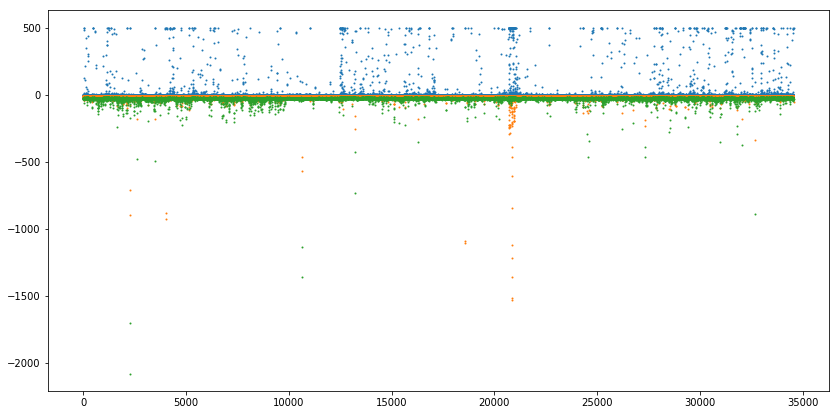

In [700]:
plt.figure(figsize=(14,7))
plt.plot(pv[:,1]*500,'.',markersize=2)
plt.plot(LLv[:,0],'.',markersize=2)
plt.plot(LLv[:,1],'.',markersize=2)
# plt.vlines(starts[1:],-1000,0,linestyles=':')
# plt.vlines(ends[1:],-1000,0,linestyles=':')

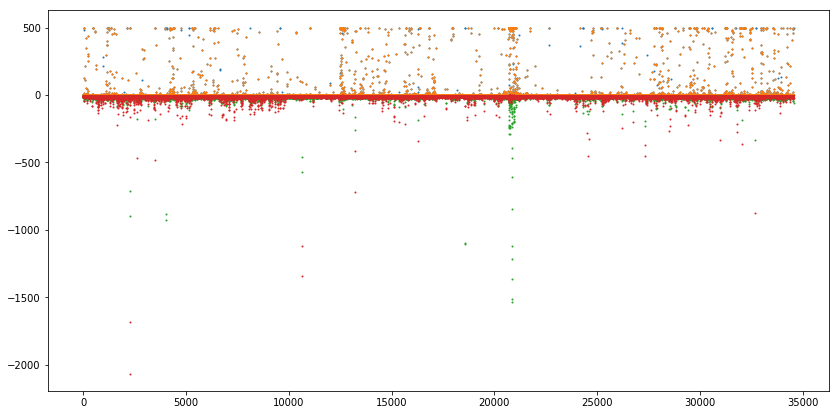

In [701]:
th = stats.chi2.isf(1e-3,15,scale=0.5)
plt.figure(figsize=(14,7))


plt.plot(pv[:,1]*500,'.',markersize=2)
plt.plot((pv[:,1]*(-R2v[:,1]<th))*500,'.',markersize=2)
# plt.plot((-R2v[:,1]<th)*500,'-',markersize=2)
plt.plot(R2v[:,0],'.',markersize=2)
plt.plot(R2v[:,1],'.',markersize=2)

In [645]:
@jit(nopython=True)
def LL2prob_jit(LL,prob):
    for i in range(LL.shape[0]):
        v = np.exp(LL[i,:])
        prob[i,:] = v / np.sum(v)
        
def LL2prob(LL):
    prob = np.zeros(LL.shape)
    LL2prob_jit(LL,prob)
    return prob

In [646]:
import hmm_pyecog
importlib.reload(hmm_pyecog)

<module 'hmm_pyecog' from '../hmm_pyecog.py'>

In [647]:
# HMM = hmm_pyecog.HMM_LL()
HMM = GC.hmm

In [649]:
HMM.A

array([[9.99956519e-01, 4.34807815e-05, 0.00000000e+00],
       [4.83870968e-02, 9.51612903e-01, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [702]:
p  = LL2prob(LLv).T
pf = HMM.forward_backward(LLv.T)
starts = np.diff(((pf[1,:].T*(-R2v[:,1]<th)))>.5)>0
ends =  np.diff(((pf[1,:].T*(-R2v[:,1]<th))>.5).astype('int'))<0

../hmm_pyecog.py:245: RuntimeWarning: divide by zero encountered in log
  alpha[:, 0] = log_phi[:, 0] + np.log(stationary_dist)
../hmm_pyecog.py:249: RuntimeWarning: divide by zero encountered in log
  alpha_t = log_phi[:, t] + np.log(np.dot(exp_alpha_t.T, A))  # sure no undeflow here...
../hmm_pyecog.py:284: RuntimeWarning: divide by zero encountered in log
  beta[:, t] = np.log(beta_t) + max_beta_t


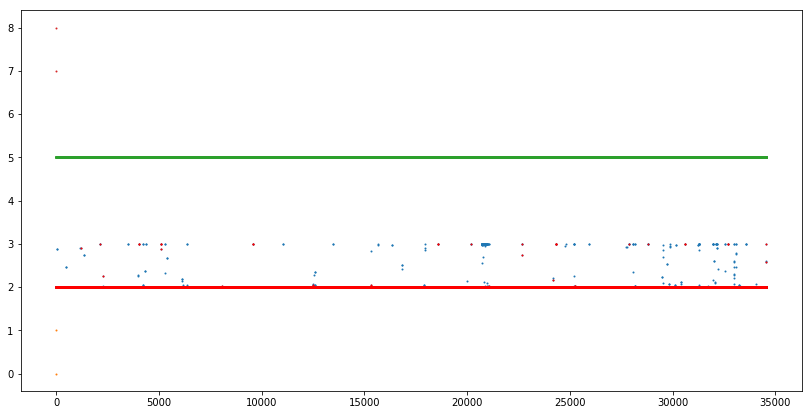

In [753]:
plt.figure(figsize=(14,7))
plt.plot(pf[1,:].T+2,'.',markersize=2)
plt.plot((pf[1,:].T*(-R2v[:,1]>th))+2,'r.',markersize=2)
plt.plot(p[1,:].T,'.',markersize=2)
plt.plot(pf[2,:].T+5,'.',markersize=2)
plt.plot(p[2,:].T+7,'.',markersize=2)
# plt.plot(p[1,:].T-pf[1,:].T-2,'.',markersize=2)

th = stats.chi2.isf(1e-3,15,scale=0.5)
# plt.xlim(20000,22050)

In [754]:
np.sum(np.diff((pf[1,:]>.5).astype('int')>0))


123

In [755]:
starts = np.nonzero(np.diff(((pf[1,:].T*(-R2v[:,1]<th))>.5).astype('int'))>0)[0]
ends =   np.nonzero(np.diff(((pf[1,:].T*(-R2v[:,1]<th))>.5).astype('int'))<0)[0]

In [756]:
len(starts)

55

In [757]:
np.tile(np.eye(10),(5,1,1)).shape

(5, 10, 10)

(20600, 21500)

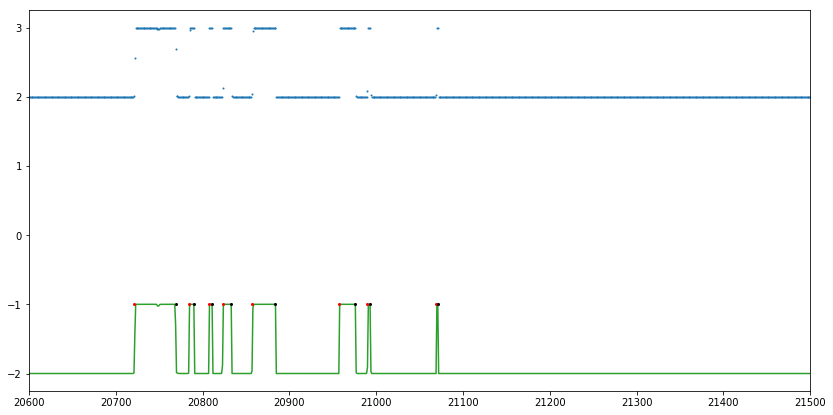

In [759]:
r = (20600,21500)

plt.figure(figsize=(14,7))
plt.plot(pf[1,:].T+2,'.',markersize=2)
plt.plot(p[1,:].T,'.',markersize=2)
# plt.plot(p[1,:].T-pf[1,:].T-2,'.',markersize=2)

th = stats.chi2.isf(1e-3,15,scale=0.5)
plt.plot((pf[1,:].T*(-R2v[:,1]<th))-2,'-',markersize=2)
plt.plot(starts,starts*0-1,'o',markersize=2,color='r')
plt.plot(ends,ends*0-1,'o',markersize=2,color='k')
plt.xlim(*r)

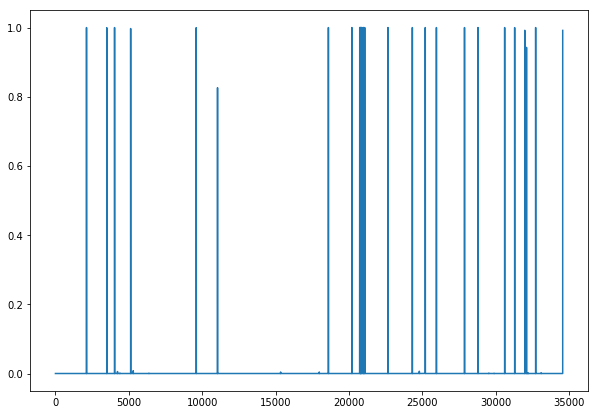

In [125]:
plt.figure(figsize=(10,7))
plt.plot(pf[1,:])
plt.show()

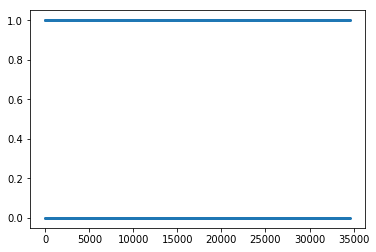

In [126]:
th = stats.chi2.isf(1e-1,15,scale=0.5)
plt.plot((-R2v[:,1]<th),'.',markersize=2)

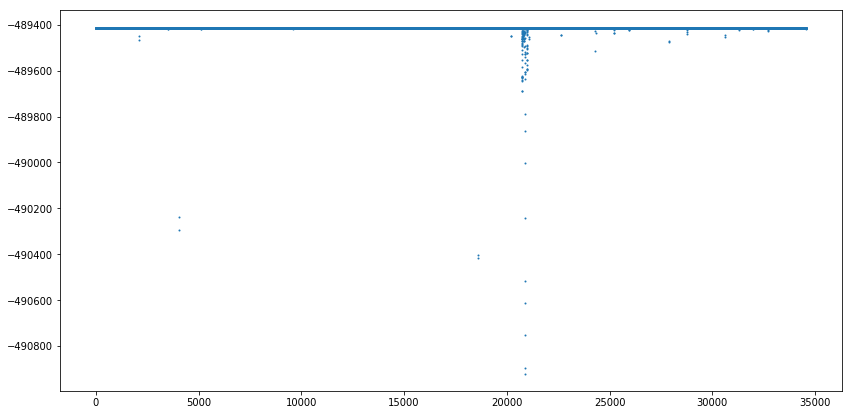

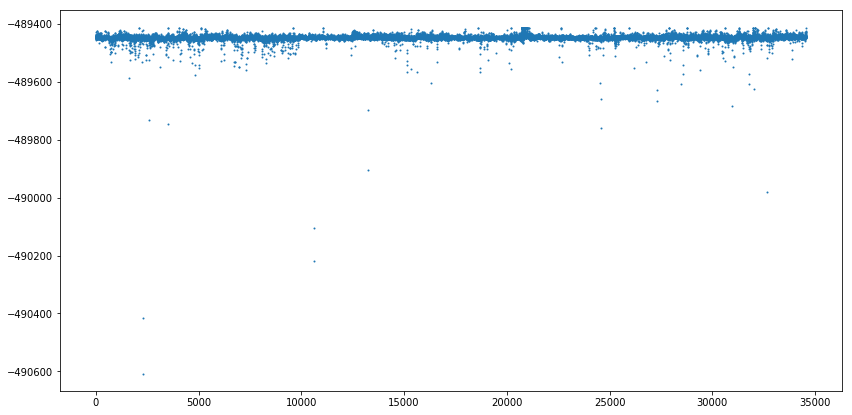

In [127]:

plt.figure(figsize=(14,7))
plt.plot((HMM.alpha[0,:] + HMM.beta[0,:]).T,'.',markersize=2)
plt.figure(figsize=(14,7))
plt.plot((HMM.alpha[1,:] + HMM.beta[1,:]).T,'.',markersize=2)

(20000, 22000)

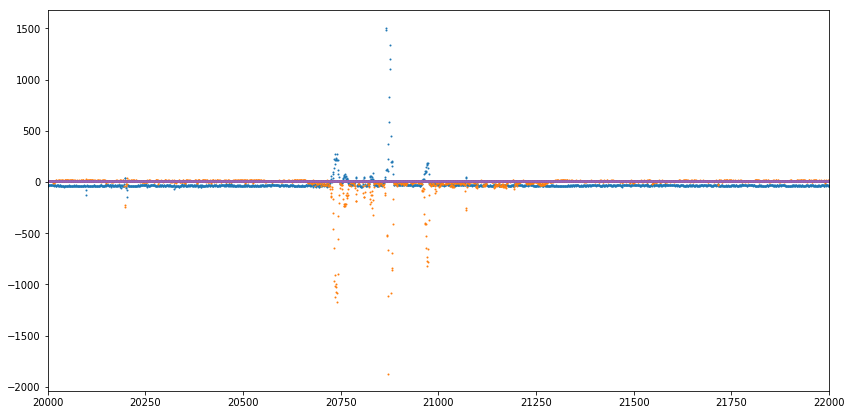

In [128]:
plt.figure(figsize=(14,7))
plt.plot(np.diff(HMM.beta.T+HMM.alpha.T,axis=1),'.',markersize=2)

plt.plot(HMM.posterior.T+10,'.',markersize=2)
plt.xlim(20000,22000)

/home/mfpleite/anaconda3/envs/pyecog2_env/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/mfpleite/anaconda3/envs/pyecog2_env/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


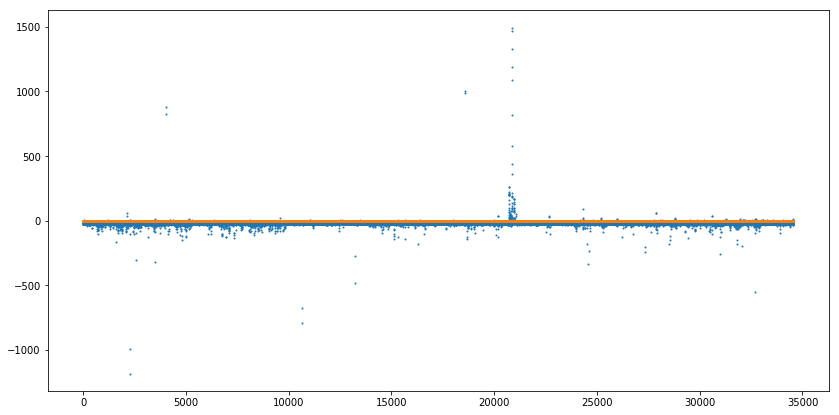

In [129]:
plt.figure(figsize=(14,7))
# plt.plot(pv[:,1]*500,'.',markersize=2)
plt.plot(LLv[:,1] - LLv[:,0],'.',markersize=2)
plt.plot(np.exp(LLv[:,1] - LLv[:,0])/np.exp(LLv[:,1] - LLv[:,0]),'.',markersize=2)
# plt.plot(LLv[:,1],'.',markersize=2)
# plt.plot(HMM.phi.T,'.',markersize=2)
# plt.xlim(20000,22000)

In [130]:
LLf =(HMM.alpha+HMM.beta).T

In [131]:
dLLf = np.diff(LLf,axis=1)
dLLv = np.diff(LLv,axis=1)

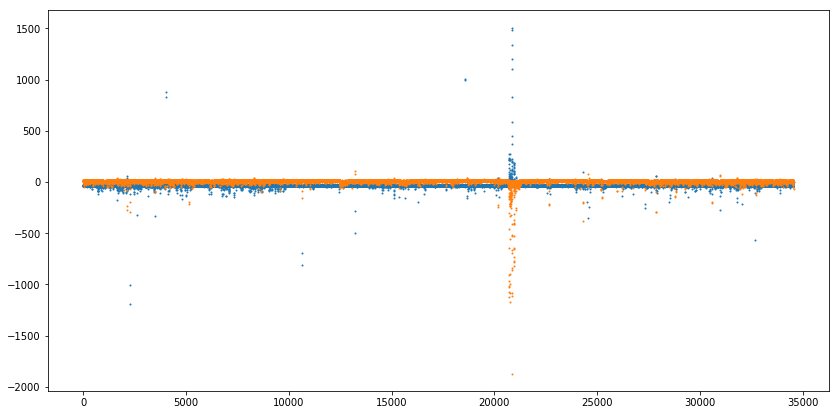

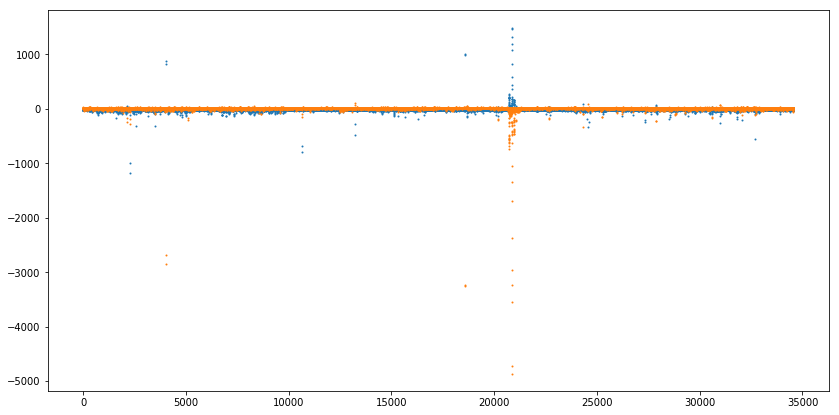

In [132]:
plt.figure(figsize=(14,7))
plt.plot(dLLf,'.',markersize=2)
plt.figure(figsize=(14,7))
plt.plot(dLLv,'.',markersize=2)

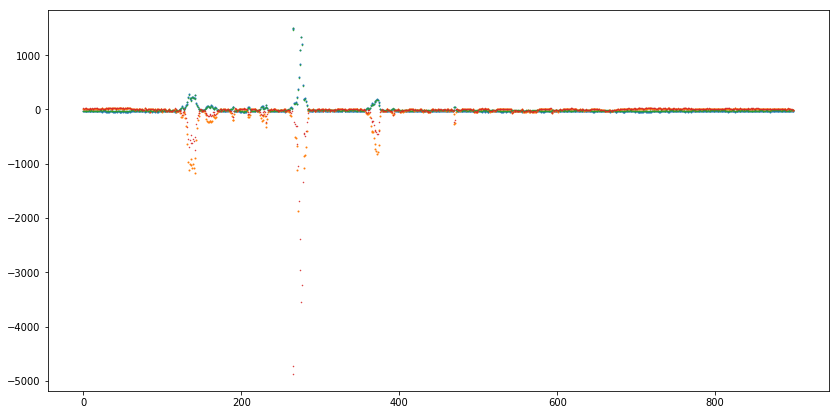

In [133]:
r = range(20600,21500)
plt.figure(figsize=(14,7))
plt.plot(dLLf[r],'.',markersize=2)
plt.plot(dLLv[r],'.',markersize=1)


In [405]:
a = {'b':[[1,2],[6,7]],
     'c':[[2,3],[8,9]]
    }
keys = ['b','c']

In [412]:
d = [(l[0],l[1],i+1) for i,key in enumerate(keys) for l in a[key]]
d

[(1, 2, 1), (6, 7, 1), (2, 3, 2), (8, 9, 2)]

In [413]:
d.sort()
d

[(1, 2, 1), (2, 3, 2), (6, 7, 1), (8, 9, 2)]

In [481]:
dt=.5
def transitions2matrix(t,dt,n):
    A = np.zeros((n+1,n+1))
    A[0,d[0][2]] +=1
    for i in range(len(t)-1):
        if t[i][1] >= t[i+1][0]-dt: # transitions between labled events
            A[t[i][2],t[i+1][2]] +=1
        else:  # transitions between labled events and blanks
            A[t[i][2],0]   +=1
            A[0,t[i+1][2]] += 1
    return A

def tansitions2rates(B,nblankpoints,nclasspoints):
    A = B
    A[0,0] = nblankpoints - np.sum(A[0,:])
    A[0,:] /= np.sum(A[0,:])
    for i in range(len(nclasspoints)):
        if nclasspoints[i]:
            A[i+1,i+1] = nclasspoints[i] - np.sum(A[i+1,:])
            A[i+1,:] /= np.sum(A[i+1,:])
        else: # For classes that do not occur, default to transition to blanks
            A[i+1,:] = 0
            A[i+1,0] = 1
    return A

In [482]:
A = np.zeros((3,3),dtype='float64')
A = transitions2matrix(d,.5,3)

In [483]:
B  = tansitions2rates(A,100,[10,5,0])

In [484]:
B

array([[0.97, 0.02, 0.01, 0.  ],
       [0.1 , 0.8 , 0.1 , 0.  ],
       [0.2 , 0.  , 0.8 , 0.  ],
       [1.  , 0.  , 0.  , 0.  ]])

In [661]:
tv = []
for i in range(10):
    t =np.arange(100)
    tv.append(t)
tvs = np.hstack(tv)

In [662]:
tvs.shape

(1000,)

In [3]:
6//10

0

In [4]:
1.58496687e+09

1584966870.0

In [5]:
1572565228.494363 + 3600

1572568828.494363

In [198]:
any([False, True, False])

True

In [79]:
def intervals_overlap(a,b):
    return (a[0] <= b[0] < a[1]) or (a[0] <= b[1] < a[1]) or (b[0] <= a[0] < b[1]) or (b[0] <= a[1] < b[1])



In [80]:
manual_label_positions = [[0,.5],[3,4],[7,8]]

In [83]:
if not any([intervals_overlap([.1,2],pos) for pos in manual_label_positions]):
    print('do it')
else:
    print('skip it')


skip it
